In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/orion/projects/RDaly2023/MCMC-fitting/Merloni+03/Original-M03.csv', 
                 header=0, skiprows=[1,2])
df

,Object,D(Mpc),type,Log(L_R),Log(L_x),Log(M)
0,Ark 564,99.0000,NS1,38.59,43.74,6.50
1,Cyg A,224.0000,S2/L2,41.43,44.22,9.40
2,Fairall 9,199.8000,S1,37.68,44.14,7.91
3,IC 1459,29.2000,L2,39.71,40.66,9.00
4,IC 4296 (PKS 1333-33),188.0000,L1.9,39.68,41.20,9.10
...,...,...,...,...,...,...
144,XTE J1118+480,0.0018,GBH,28.92,35.47,1.00
145,XTE J1118+480,0.0018,GBH,28.92,35.45,1.00
146,XTE J1859+226,0.0110,GBH,29.24,36.58,0.88
147,XTE J1859+226,0.0110,GBH,29.30,36.65,0.88


In [3]:
df.rename(columns={'Log(L_R)':'logR', 'Log(L_x)': 'logX', 'Log(M)' : 'logM'}, inplace=True)

Text(0, 0.5, 'log R')

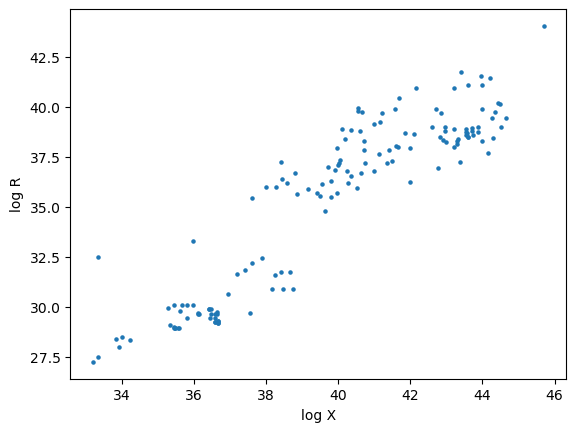

In [4]:
plt.scatter(df['logX'], df['logR'], s=5)
plt.xlabel('log X')
plt.ylabel('log R')

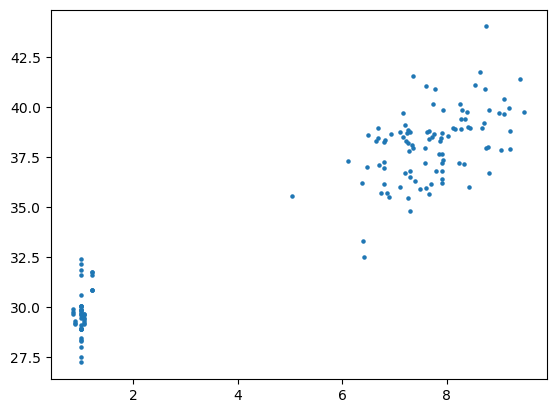

In [5]:
plt.scatter(df['logM'], df['logR'], s=5)

In [6]:
def statmodel_fit(x, y):

    x = sm.add_constant(x) # adding a constant
 
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
 
    print_model = model.summary()
    print(print_model)

In [7]:
xaxis = df[['logX','logM']]
yaxis = df['logR']

statmodel_fit(xaxis, yaxis)

                            OLS Regression Results                            
Dep. Variable:                   logR   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1734.
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          1.87e-102
Time:                        08:07:24   Log-Likelihood:                -188.57
No. Observations:                 149   AIC:                             383.1
Df Residuals:                     146   BIC:                             392.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1948      1.347      5.339      0.0

In [8]:
#true values 

m1_true = 0.60
m2_true = 0.78
b_true = 7.19
f_true = 0.88 

In [19]:
df['logX_err'] = df['logX'].std()
df['logM_err'] = np.random.uniform(0.01, 1.00, 149)

x = df[['logX','logM']]
y = df['logR']

yerr = np.sqrt(df['logX_err']**2 + df['logM_err']**2)  # adding in quardrature 
yerr

0      3.214319
1      3.202129
2      3.296307
3      3.210591
4      3.202968
         ...   
144    3.247851
145    3.190040
146    3.191895
147    3.258942
148    3.190018
Length: 149, dtype: float64

In [20]:
def log_likelihood(theta, x1, x2, y, yerr):
    m1, m2, b, log_f = theta
    model = m1 * x1 + m2 * x2 + b             
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


In [21]:
x1 = x.to_numpy()[:,0]   
x2 = x.to_numpy()[:,1]

In [22]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m1_true, m2_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(x1, x2, y, yerr))
m1_ml, m2_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(m1_ml))
print("b = {0:.3f}".format(m2_ml))
print("const = {0:.3f}".format(b_ml))
print("log_f = {0:.5f}".format(log_f_ml))       


Maximum likelihood estimates:
a = 0.601
b = 0.768
const = 7.184
log_f = -11.73217


In [23]:
# MCMC

In [24]:
def log_prior(theta):
    m1, m2, b, log_f = theta
    if -5.0 < m1 < 5.0 and -5.0 < m2 < 5.0 and -5.0 < b < 15.0 and -20.0 < log_f < 5.0:
                            # use max-likelihood fit results to predict the range of params
        return 0.0
    return -np.inf

def log_probability(theta, x1, x2, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr)


In [25]:
ndim, nwalkers = 4, 10
pos = [soln.x + 1e-1 * np.random.randn(ndim) for i in range(nwalkers)]


In [26]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x1, x2, y, yerr))

sampler.run_mcmc(pos, 500, progress=True);         #the colon prevents hidden print command apparently

100%|█████████████████████████████████████████████| 500/500 [00:02<00:00, 178.39it/s]


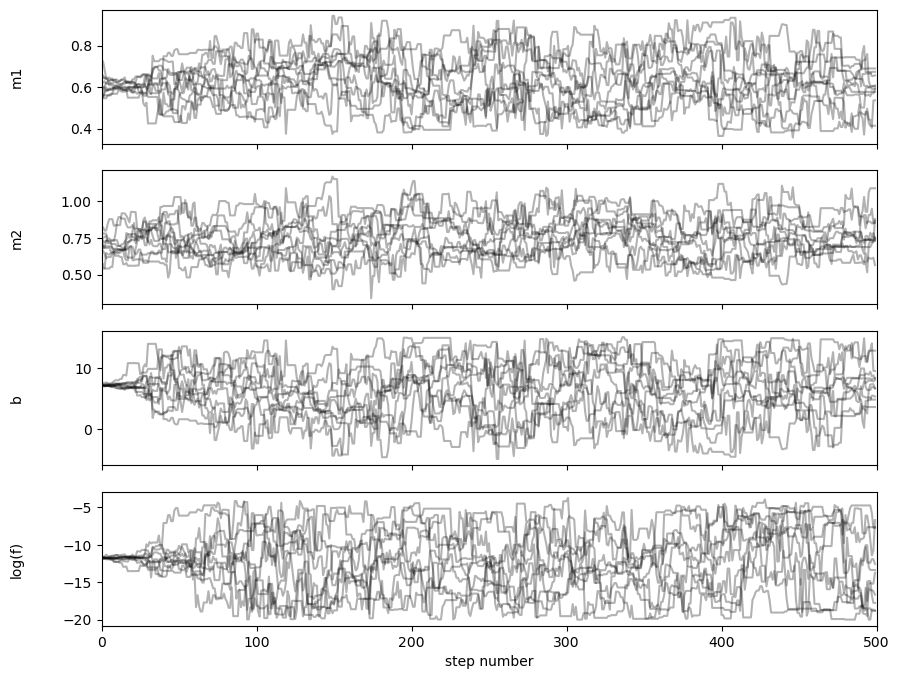

In [27]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [28]:
sampler.reset()
sampler.run_mcmc(pos, 10000, progress=True);

100%|█████████████████████████████████████████| 10000/10000 [00:55<00:00, 180.12it/s]


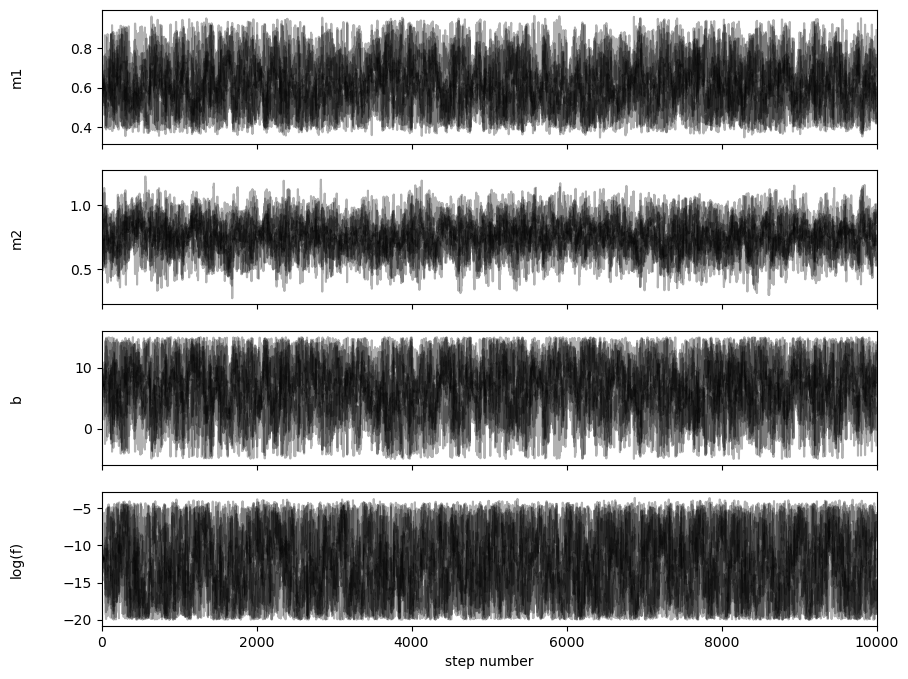

In [29]:
fig, axes = plt.subplots(4, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["m1", "m2", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [30]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(6330, 4)


In [31]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
print(sample)

[ 0.61897782  0.67905299  6.83176195 -9.4982965 ]


In [32]:
for ind in inds:
    sample = flat_samples[ind]
    print(sample)

[  0.44720368   0.73958629  13.37105302 -14.62046258]
[  0.61134578   0.66174636   7.96250878 -13.26949421]
[  0.75230595   0.67917137   1.87513315 -12.27880926]
[  0.62548589   0.72378982   6.53838293 -13.80148286]
[  0.86428824   0.57939567  -2.6468023  -19.72535291]
[ 0.5185757   0.8424695   9.67365107 -8.5554513 ]
[  0.83140061   0.66236934  -1.53662425 -14.30614211]
[  0.46567641   0.90773     11.69330097 -18.88034189]
[  0.80415056   0.39453869   1.07636464 -14.39764026]
[  0.76402518   0.53782177   2.05227259 -15.9428927 ]
[  0.68716478   0.6933679    4.16226249 -12.48730275]
[  0.43417733   1.03064256  12.39895929 -19.35005047]
[  0.57732815   0.70783766   8.5536038  -12.61195848]
[  0.55708324   0.90969131   8.17690425 -10.66520352]
[ 0.70794872  0.60187216  3.69705714 -9.52532033]
[  0.69977472   0.71378709   3.25434352 -12.23594228]
[  0.73049897   0.73895755   2.16062543 -11.46840038]
[  0.77292993   0.578464     1.51769339 -18.36479187]
[  0.50890634   0.80024708  10.67896

In [33]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [10, 50, 90])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

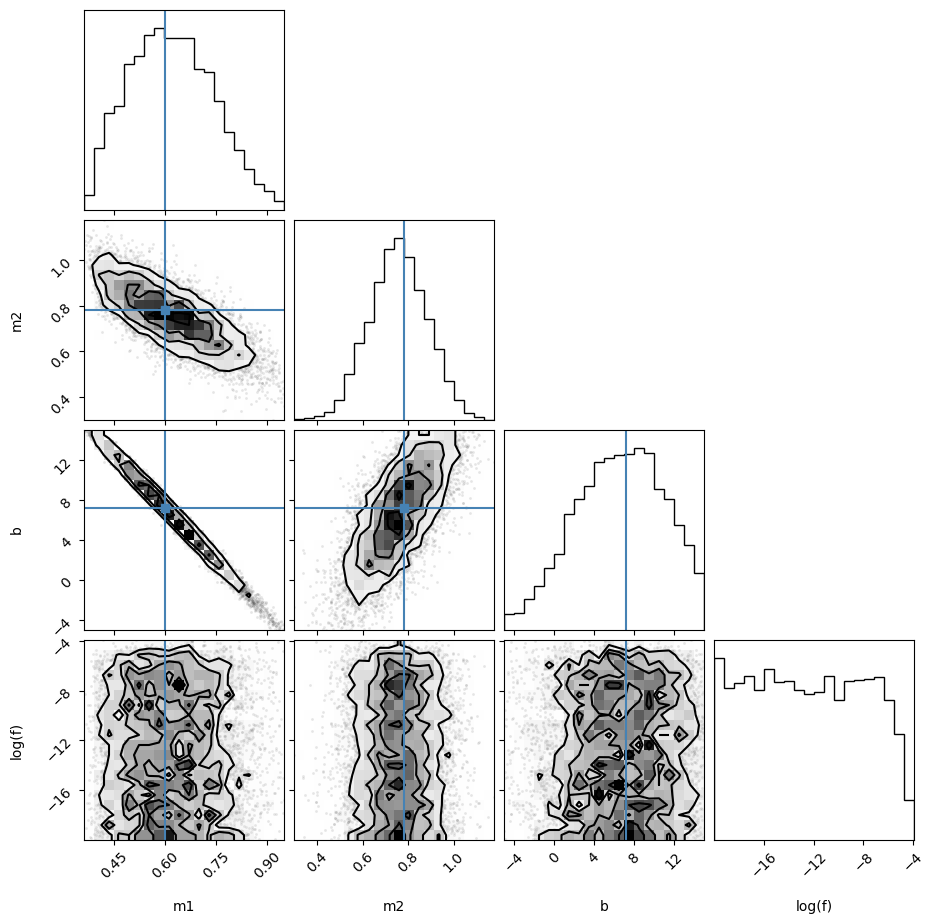

In [34]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m1_true, m2_true, b_true, np.log(f_true)]
)